In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-02-preprocessing-and-feature-engineering/X_test_processed.npy
/kaggle/input/telco-02-preprocessing-and-feature-engineering/X_train_processed.npy
/kaggle/input/telco-02-preprocessing-and-feature-engineering/preprocessor.joblib
/kaggle/input/telco-02-preprocessing-and-feature-engineering/y_test.csv
/kaggle/input/telco-02-preprocessing-and-feature-engineering/y_train.csv
/kaggle/input/telco-02-preprocessing-and-feature-engineering/__results__.html
/kaggle/input/telco-02-preprocessing-and-feature-engineering/__notebook__.ipynb
/kaggle/input/telco-02-preprocessing-and-feature-engineering/__output__.json
/kaggle/input/telco-02-preprocessing-and-feature-engineering/custom.css


In [10]:
import joblib
input_dir = '/kaggle/input/telco-02-preprocessing-and-feature-engineering/'
X_train_processed = np.load(input_dir + 'X_train_processed.npy')
X_test_processed = np.load(input_dir + 'X_test_processed.npy')
y_train = pd.read_csv(input_dir + 'y_train.csv').squeeze()
y_test = pd.read_csv(input_dir + 'y_test.csv').squeeze()
preprocessor = joblib.load(input_dir + 'preprocessor.joblib')
print("## Data and Preprocessor Loaded Successfully ##")
print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Preprocessor object:\n {preprocessor}")

## Data and Preprocessor Loaded Successfully ##
Shape of X_train_processed: (5634, 45)
Shape of y_train: (5634,)
Preprocessor object:
 ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])


In [11]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_processed, y_train)
y_pred_lr = log_reg.predict(X_test_processed)
print("## Baseline Model (Logistic Regression) Trained Successfully ##")
print(f"First 5 predictions: {y_pred_lr[:5]}")

## Baseline Model (Logistic Regression) Trained Successfully ##
First 5 predictions: ['No' 'Yes' 'No' 'No' 'No']


## Classification Report (Logistic Regression) ##
              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


## Confusion Matrix ##


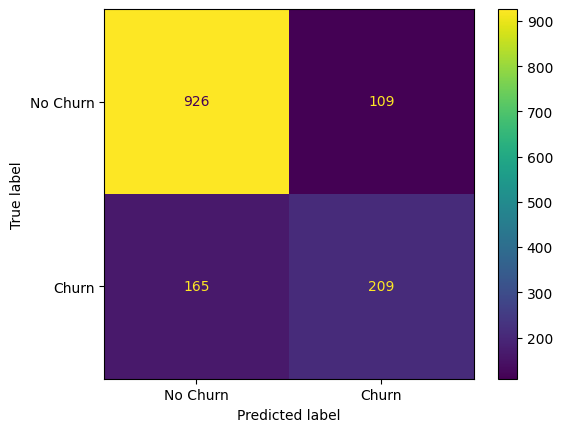

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print("## Classification Report (Logistic Regression) ##")
print(classification_report(y_test, y_pred_lr))
print("\n## Confusion Matrix ##")
cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()
plt.show()

In [13]:
y_train_encoded = y_train.map({'No': 0, 'Yes': 1})
y_test_encoded = y_test.map({'No': 0, 'Yes': 1})
print("Target variable encoded successfully.")
print(f"Original y_train values: {y_train.unique()}")
print(f"Encoded y_train values: {y_train_encoded.unique()}")

Target variable encoded successfully.
Original y_train values: ['No' 'Yes']
Encoded y_train values: [0 1]


## Classification Report (XGBoost) ##
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.52      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409


## Confusion Matrix (XGBoost) ##


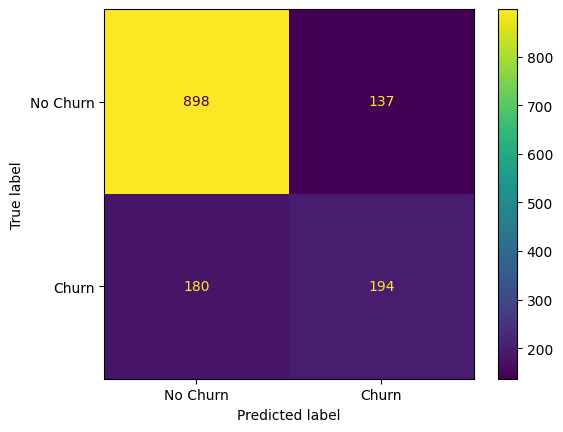

In [14]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_processed, y_train_encoded) 
y_pred_xgb = xgb_model.predict(X_test_processed)
print("## Classification Report (XGBoost) ##")
print(classification_report(y_test_encoded, y_pred_xgb)) 
print("\n## Confusion Matrix (XGBoost) ##")
cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['No Churn', 'Churn'])
disp_xgb.plot()
plt.show()

Class Weight to use: 2.77


## Classification Report (XGBoost with Class Weighting) ##
              precision    recall  f1-score   support

           0       0.87      0.79      0.82      1035
           1       0.53      0.66      0.59       374

    accuracy                           0.75      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.75      0.76      1409


## Confusion Matrix (XGBoost with Class Weighting) ##


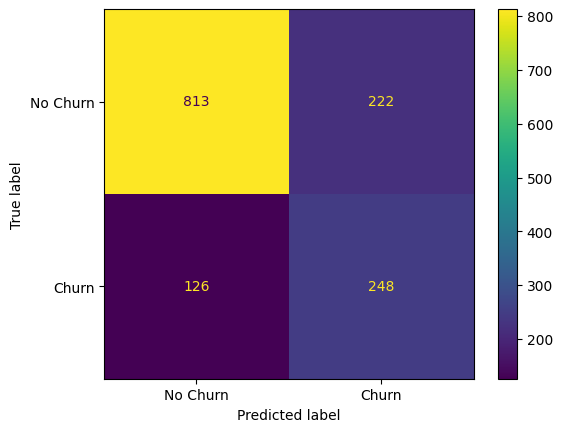

In [15]:
scale_pos_weight = y_train.value_counts()['No'] / y_train.value_counts()['Yes']
print(f"Class Weight to use: {scale_pos_weight:.2f}")
xgb_weighted = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
xgb_weighted.fit(X_train_processed, y_train_encoded)
y_pred_weighted = xgb_weighted.predict(X_test_processed)
print("\n\n## Classification Report (XGBoost with Class Weighting) ##")
print(classification_report(y_test_encoded, y_pred_weighted))
print("\n## Confusion Matrix (XGBoost with Class Weighting) ##")
cm_weighted = confusion_matrix(y_test_encoded, y_pred_weighted)
disp_weighted = ConfusionMatrixDisplay(confusion_matrix=cm_weighted, display_labels=['No Churn', 'Churn'])
disp_weighted.plot()
plt.show()

Starting hyperparameter search... (This may take several minutes)
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=300; total time=   0.6s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=300; total time=   0.6s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.05, max_depth=7, n_estimators=300; total time=   0.6s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.3s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=4, n_estimators=200; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=300; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=4, n_estimators=300; total time

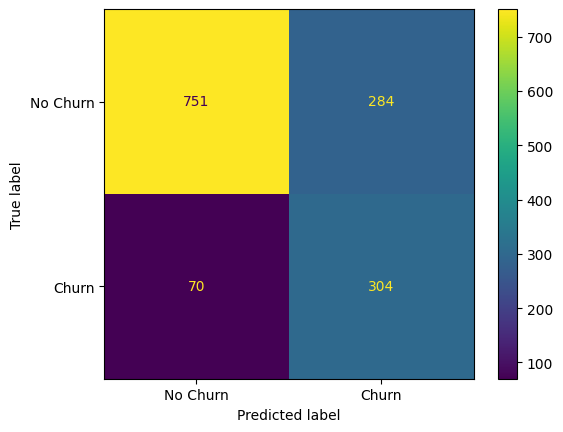

In [16]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.7, 1.0]
}
scale_pos_weight = y_train.value_counts()['No'] / y_train.value_counts()['Yes']
xgb_base = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='recall' 
)
print("Starting hyperparameter search... (This may take several minutes)")
random_search.fit(X_train_processed, y_train_encoded)
print("\nSearch complete.")
print(f"Best parameters found: {random_search.best_params_}")
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test_processed)
print("\n\n## Classification Report (Tuned XGBoost Model) ##")
print(classification_report(y_test_encoded, y_pred_best))
print("\n## Confusion Matrix (Tuned XGBoost Model) ##")
cm_best = confusion_matrix(y_test_encoded, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['No Churn', 'Churn'])
disp_best.plot()
plt.show()

In [17]:
try:
    import shap
    # If the import is successful, print the installed version
    print(f"✅ SHAP is installed. Version: {shap.__version__}")
except ImportError:
    # If the import fails, print a message indicating it's not installed
    print("❌ SHAP is NOT installed.")

✅ SHAP is installed. Version: 0.44.1

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=6, n_estimators=200; total time=   0.6s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.2, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=7, n_estimators=200; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5, n_estimators=400; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=3, n_es

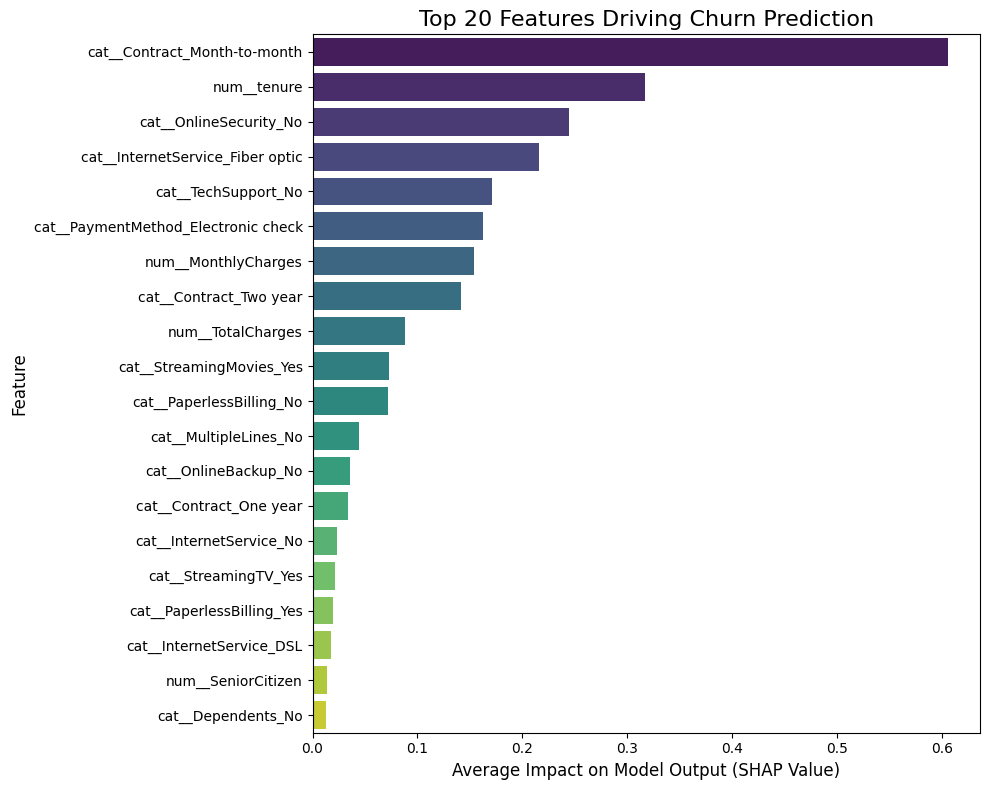

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_names = preprocessor.get_feature_names_out()
shap_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
})
top_20_features = shap_df.sort_values(by='importance', ascending=False).head(20)
plt.figure(figsize=(10, 8)) 
sns.barplot(
    x='importance',
    y='feature',
    data=top_20_features,
    orient='h',
    palette='viridis' 
)
plt.title('Top 20 Features Driving Churn Prediction', fontsize=16)
plt.xlabel('Average Impact on Model Output (SHAP Value)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() 
plt.show()